# Auswertung

## Numerische Frequenzanalyse

Die Frequenzspektren werden mittels der Fastfouriertransformation (fft) analysiert. Die Funktion ist im *numpy* Modul für Python bereits integriert und erfordert lediglich den datensatz und ein paar Parameter. Die Höhe und Breite der Peaks werden mittels einer einfachen Gaussfunktion gefittet. 

### Python Module

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm
from decimal import Decimal
import io
from scipy.optimize import curve_fit
from scipy.stats import chi2
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = 16, 9

### Funktionen

In [2]:
def sig(val1,err1,val2,err2):
    sig = np.abs(val2-val1)**2/np.abs(np.abs(err2)+np.abs(err1))**2
    return round(sig,3)

def format_e(n):
    a = '%e' % Decimal(n)
    return a.split('e')[0].rstrip('0').rstrip('.')+'e'+a.split('e')[1]

def form(val,err):
        a = "{value:4.3f} ± {error:4.3f}".format(value=val,error=err)
        return a

def format_plt(n):
    a = '%e' % Decimal(n)
    b = r'${'+a.split('e')[0].rstrip('0').rstrip('.')+'}}$'+r'${*10^{'+a.split('e')[1]+'}}$'
    return b

def comma_to_float(valstr):
    return float(valstr.decode('utf-8').replace(',','.'))

def open_data(n):
    filename = 'data/Messung'+str(n)+'.txt'
    X,Y1,Y2 = np.loadtxt(filename,skiprows=2,usecols=(0,1,2),
                         converters={0:comma_to_float,1:comma_to_float, 
                                     2:comma_to_float},
                         unpack=True)
    return X,Y1,Y2

def gaussian(x, y, mu, sig):
    return norm.pdf(x, mu, sig)*y
def gaussian2(x, y1, mu1, sig1, y2, mu2, sig2):
    return norm.pdf(x, mu1,sig1)*y1+norm.pdf(x, mu2,sig2)*y2


def fastfourier(n):
    t, phi1, phi2 = open_data(n)
    
    timestep = 0.025

    #Fouriertransformation mit zeropadding
    spektrum_1 = np.fft.fft(np.concatenate((phi1, np.zeros(2*len(phi1)))))
    spektrum_2 = np.fft.fft(np.concatenate((phi2, np.zeros(2*len(phi2)))))  

    #spektrum = np.fft.fft  #Fouriertransformation    
    freq_1 = np.fft.fftfreq(spektrum_1.size, timestep)
    freq_2 = np.fft.fftfreq(spektrum_2.size, timestep)

    n_1=spektrum_1.size   #Nur positive Werte
    n_2=spektrum_2.size

    n_halb_1 = np.ceil(n_1/2.0)
    n_halb_2 = np.ceil(n_2/2.0)
    spektrum_halb_1 = (2.0 / int(n_1)) * spektrum_1[0:int(n_halb_1)]
    spektrum_halb_2 = (2.0 / int(n_2)) * spektrum_2[0:int(n_halb_2)]
    freq_halb_1 = freq_1[0:int(n_halb_1)]
    freq_halb_2 = freq_2[0:int(n_halb_2)]
    amplitude_1 =np.abs(spektrum_halb_1)
    amplitude_2 =np.abs(spektrum_halb_2)
    return freq_halb_1, amplitude_1, freq_halb_2, amplitude_2

def fitgüte(x,y,y_err,popt,fit_funktion):    
    chisquare=np.sum((fit_funktion(x,*popt)-y)**2/y_err**2)

    #Freiheitsgrade
    dof=dof = x.size-popt.size
    chisquare_red = chisquare/dof
    prob = round(1-chi2.cdf(chisquare,dof),2)*100 #Fitwahrscheinlichket

    print('chi_squared= ' + format_e(chisquare))
    print('chi_squared_red= ' + format_e(chisquare_red))
    print('Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: ' +
          str(prob) + ' %')

## Teil 1: Eigenfrequenzen $\omega_1$, $\omega_2$ ohne Kopplung

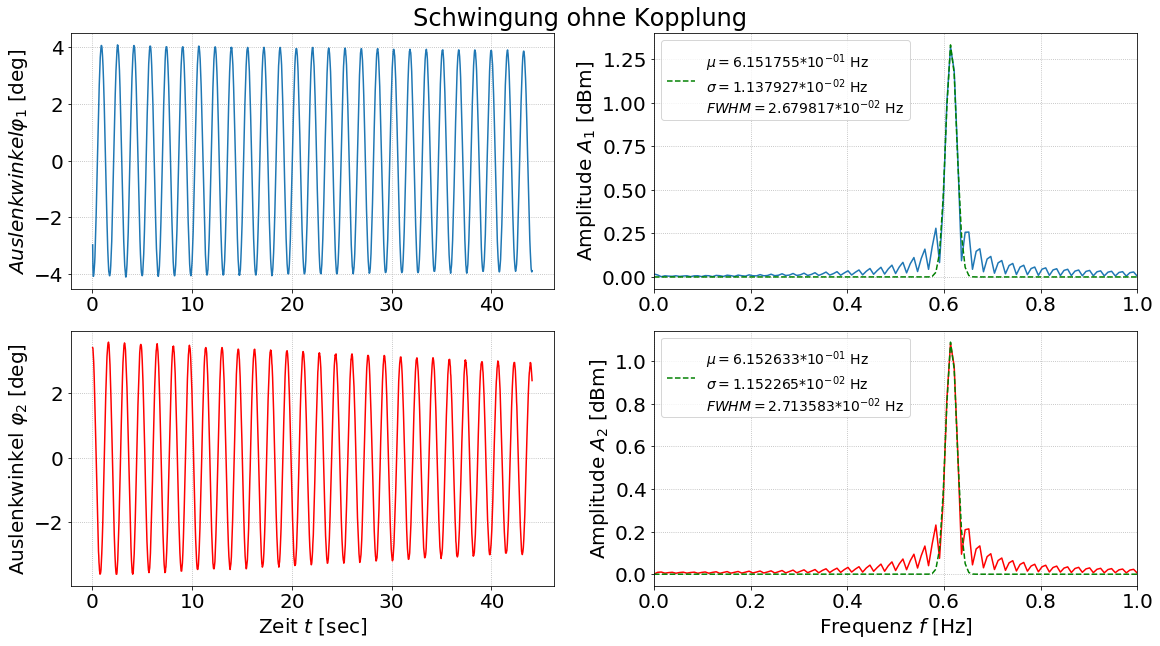


Gaussfit 1:
chi_squared= 7.851123e+02
chi_squared_red= 2.977294e-01
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Gaussfit 2:
chi_squared= 5.283554e+02
chi_squared_red= 2.003623e-01
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Eigenfrequenzen:

Pendel 1: w_1 = 0.615 ± 0.011  [Hz]
Pendel 2: w_2 = 0.615 ± 0.012  [Hz]
=> sig =  0.0 



In [3]:
def plot_schwingung(n,title):
    t, phi1, phi2 = open_data(n)
    F1, A1, F2, A2 = fastfourier(n)
    
    popt1, pcov1 = curve_fit(gaussian,F1,A1)
    perr1 = np.sqrt(np.diag(pcov1))
    
    popt2, pcov2 = curve_fit(gaussian,F2,A2)
    perr2 = np.sqrt(np.diag(pcov2))

    fig, axs = plt.subplots(2, 2, constrained_layout=True)

    axs[0,0].plot(t, phi1)
    #axs[0].set_xlabel('time [sec]')
    axs[0,0].set_ylabel('$Auslenkwinkel \\varphi_1$ [deg]')
    axs[0,0].grid(ls=':')

    axs[1,0].plot(t, phi2,c='red')
    axs[1,0].set_xlabel('Zeit $t$ [sec]')
    axs[1,0].set_ylabel('Auslenkwinkel $\\varphi_2$ [deg]')
    axs[1,0].grid(ls=':')
    
    lim = 1
    
    axs[0,1].plot(F1, A1)
    axs[0,1].plot(F1, gaussian(F1,popt1[0],popt1[1],popt1[2]),c='g',ls='--',
                  label=r'$\mu = $'+format_plt(popt1[1])+' Hz\n'
                      +r'$\sigma = $'+format_plt(popt1[2])+' Hz\n'
                      +r'$FWHM = $'+format_plt(popt1[2]*2.355)+' Hz')
    axs[0,1].set_xlim(0,lim)
    axs[0,1].set_ylabel('Amplitude $A_1$ [dBm]')
    axs[0,1].grid(ls=':')
    axs[0,1].legend(loc='best', fontsize=14)

    axs[1,1].plot(F2, A2,c='red')
    axs[1,1].plot(F2, gaussian(F2,popt2[0],popt2[1],popt2[2]),c='g',ls='--',
                  label=r'$\mu = $'+format_plt(popt2[1])+' Hz\n'
                      +r'$\sigma = $'+format_plt(popt2[2])+' Hz\n'
                      +r'$FWHM = $'+format_plt(popt2[2]*2.355)+' Hz')
    axs[1,1].set_xlim(0,lim)
    axs[1,1].set_xlabel('Frequenz $f$ [Hz]')
    axs[1,1].set_ylabel('Amplitude $A_2$ [dBm]')
    axs[1,1].grid(ls=':')
    axs[1,1].legend(loc='best', fontsize=14)

    fig.suptitle(title)
    plt.show()
    
    w1, dw1, w2, dw2 = popt1[1], popt1[2], popt2[1], popt2[2]
    
    print('\nGaussfit 1:')
    fitgüte(F1,A1,0.025,popt1,gaussian)
    print('\nGaussfit 2:')
    fitgüte(F2,A2,0.025,popt2,gaussian)
    
    print('\nEigenfrequenzen:\n')
    print('Pendel 1: w_1 =', form(w1,dw1), ' [Hz]')
    print('Pendel 2: w_2 =', form(w2,dw2), ' [Hz]')
    print('=> sig = ',sig(w1,dw1,w2,dw2),'\n')
    
    return popt1[1], popt1[2], popt2[1], popt2[2]

E1,dE1,E2,dE2 = plot_schwingung(9,'Schwingung ohne Kopplung')

\begin{align}
    \omega_1 &= 0.615 \pm 0.027 \ \text{[Hz]}\\
    \omega_2 &= 0.615 \pm 0.027 \ \text{[Hz]}\\
    &\Rightarrow 0.000\sigma
\end{align}

Die Eigenfrequenzen $\omega_1, \ \omega_2$ sind somit eindeutig nicht voneinander verschieden. Die beiden Pendel sind somit in sehr guter Näherung identisch.

## Teil 2 Anti- und Symmetrische Schwingung mit Kopplung

### Symmetrische Schwingungen

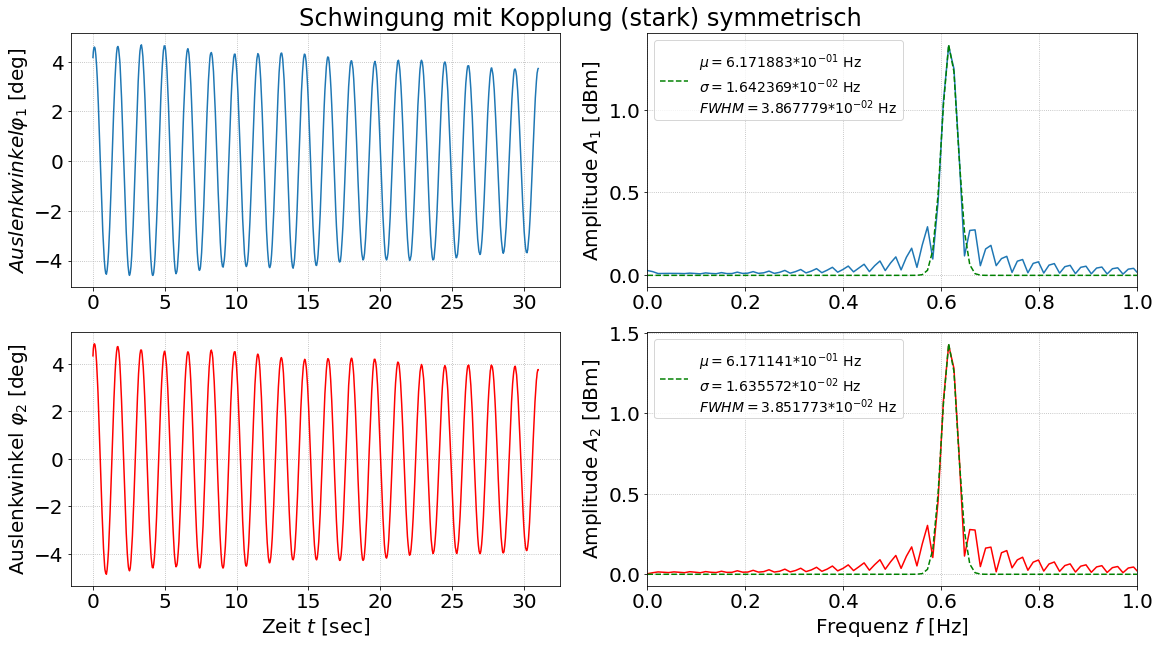


Gaussfit 1:
chi_squared= 8.608355e+02
chi_squared_red= 4.650651e-01
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Gaussfit 2:
chi_squared= 9.298682e+02
chi_squared_red= 5.023599e-01
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Eigenfrequenzen:

Pendel 1: w_1 = 0.617 ± 0.016  [Hz]
Pendel 2: w_2 = 0.617 ± 0.016  [Hz]
=> sig =  0.0 



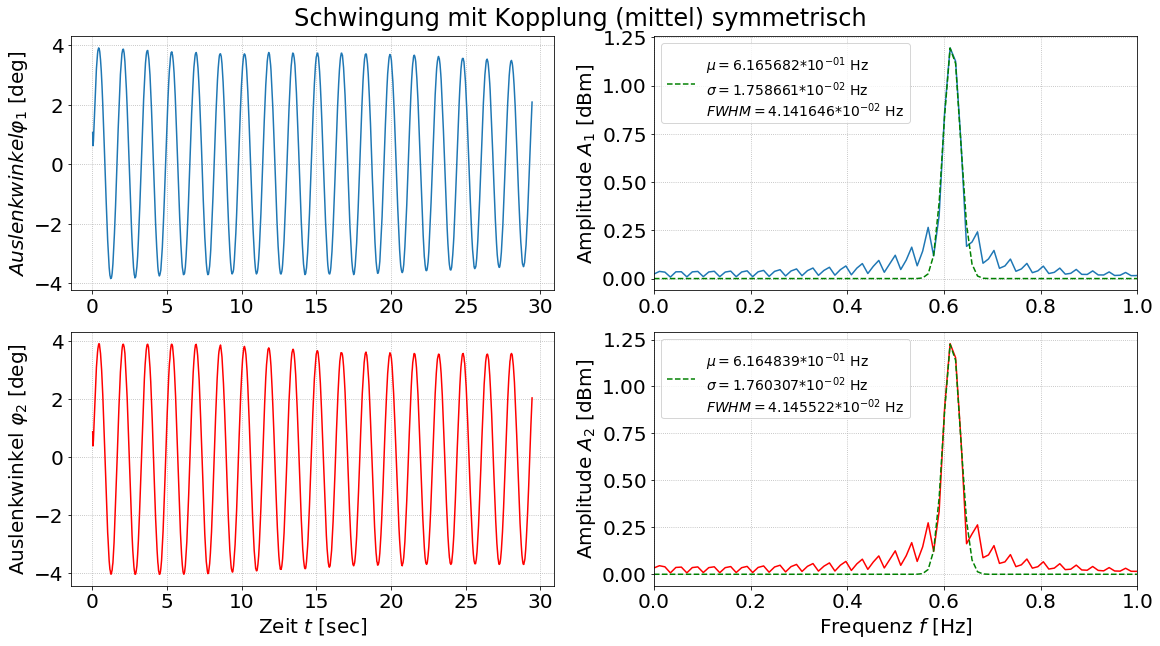


Gaussfit 1:
chi_squared= 6.247922e+02
chi_squared_red= 3.549956e-01
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Gaussfit 2:
chi_squared= 6.933806e+02
chi_squared_red= 3.939663e-01
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Eigenfrequenzen:

Pendel 1: w_1 = 0.617 ± 0.018  [Hz]
Pendel 2: w_2 = 0.616 ± 0.018  [Hz]
=> sig =  0.0 



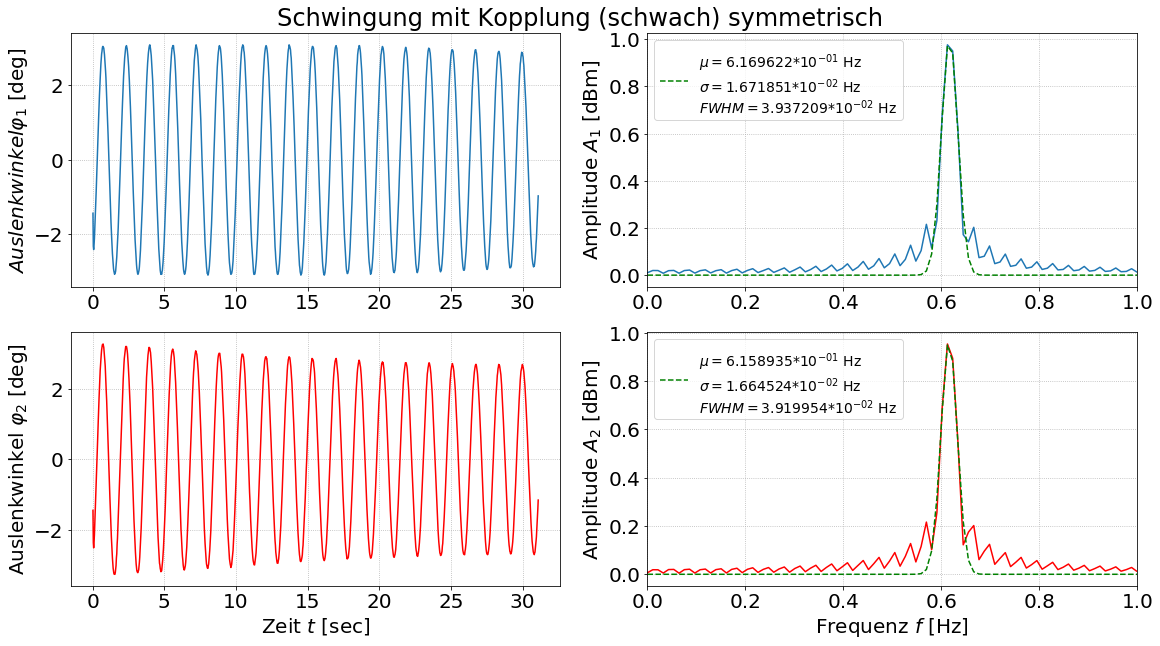


Gaussfit 1:
chi_squared= 4.0424e+02
chi_squared_red= 2.174503e-01
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Gaussfit 2:
chi_squared= 4.297384e+02
chi_squared_red= 2.311664e-01
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Eigenfrequenzen:

Pendel 1: w_1 = 0.617 ± 0.017  [Hz]
Pendel 2: w_2 = 0.616 ± 0.017  [Hz]
=> sig =  0.001 



In [4]:
S1s,dS1s,S2s,dS2s=plot_schwingung(1,'Schwingung mit Kopplung (stark) symmetrisch')
S1m,dS1m,S2m,dS2m=plot_schwingung(26,'Schwingung mit Kopplung (mittel) symmetrisch')
S1w,dS1w,S2w,dS2w=plot_schwingung(37,'Schwingung mit Kopplung (schwach) symmetrisch')

Die Eigenfrequenzen der beiden Pendel sind bei weitem nicht signifikant voneinander verschieden. Das gekoppelte System schwingt mit **einer** Frequenz. Wir wollen nun sehen ob sich diese bei verschieden Starken Kopplungen ändert.

### Berechnung der Eigenfrequenz $\omega_1^{\text{sys}}$

In [5]:
w_stark_sym, dw_stark_sym = np.mean([S1s,S2s]), dS1s+dS2s
w_mittel_sym, dw_mittel_sym = np.mean([S1m,S2m]), dS1m+dS2m
w_schwach_sym, dw_schwach_sym = np.mean([S1w,S2w]), dS1w+dS2w

print('\nEigenfrequenzen symmetrische Schwingung:\n')
print('Stark:   w_s =', form(w_stark_sym,dw_stark_sym), ' [Hz]')
print('Mittel:  w_m =', form(w_mittel_sym,dw_mittel_sym), ' [Hz]')
print('Schwach: w_w =', form(w_schwach_sym,dw_schwach_sym), ' [Hz]\n')
print('Abweichungen:\n')
print('=> sig_sm = ',sig(w_stark_sym,dw_stark_sym,w_mittel_sym,dw_mittel_sym))
print('=> sig_mw = ',sig(w_mittel_sym,dw_mittel_sym,w_schwach_sym,dw_schwach_sym))
print('=> sig_sw = ',sig(w_stark_sym,dw_stark_sym,w_schwach_sym,dw_schwach_sym))


Eigenfrequenzen symmetrische Schwingung:

Stark:   w_s = 0.617 ± 0.033  [Hz]
Mittel:  w_m = 0.617 ± 0.035  [Hz]
Schwach: w_w = 0.616 ± 0.033  [Hz]

Abweichungen:

=> sig_sm =  0.0
=> sig_mw =  0.0
=> sig_sw =  0.0


Die $\sigma$-Abweichungen sind wieder nicht signifikant. Das system Schwingt also **unabhängig** von der Kopplung mit **einer** Frequenz. Die Eigenfrequenz des symmetrischen Systems ist $\omega_1^{\text{sym}}$

\begin{align}
    \omega_{1}^{\text{sym}}&=\sqrt{\frac{D}{J}}
\end{align}

Sie ist von der Kopplung **unabhängig** und ergibt sich aus dem Mittelwert der gemessenen eigenfrequenzen der symmetrischen Schwingung.

In [6]:
w_sys = np.mean([w_stark_sym,w_mittel_sym,w_schwach_sym])
dw_sys = (max([dw_stark_sym,dw_mittel_sym,dw_schwach_sym]) 
          + np.std([w_stark_sym,w_mittel_sym,w_schwach_sym]))
print('\nEigenfrequenz der sym. Schwingung\n\nw_1_sys = ', form(w_sys,dw_sys))


Eigenfrequenz der sym. Schwingung

w_1_sys =  0.617 ± 0.036


\begin{align}
    \omega_{1}^{\text{sym}} &= 0.617 \pm 0.036 \ \text{[Hz]}
\end{align}

### Antisymmetrische Schwingung

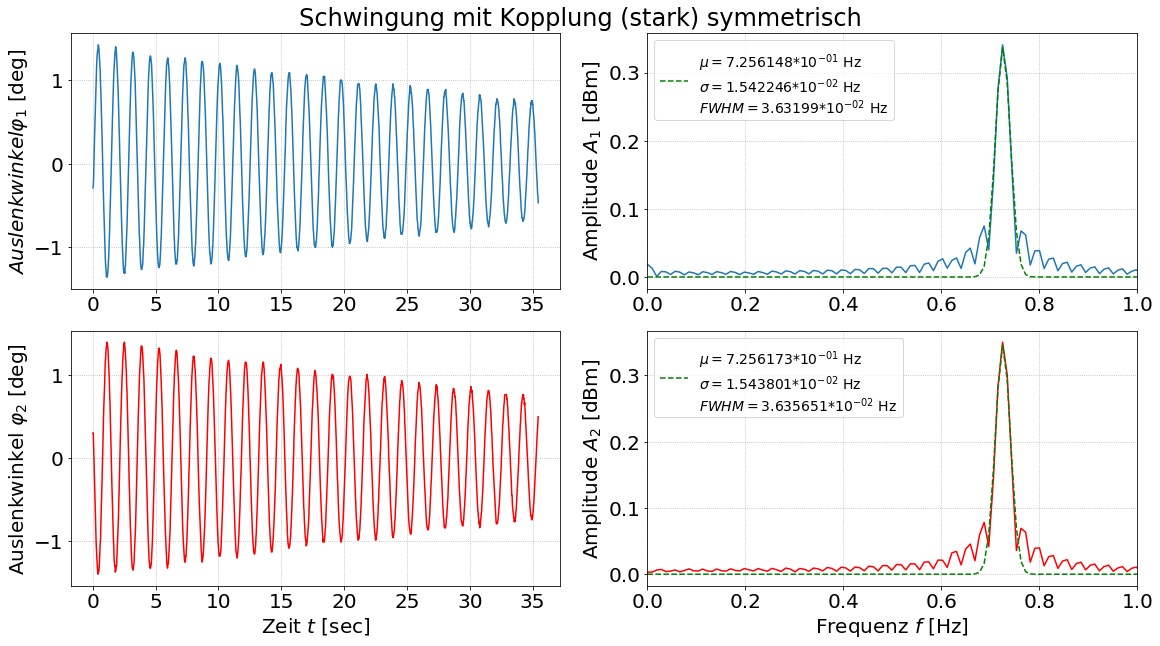


Gaussfit 1:
chi_squared= 5.591189e+01
chi_squared_red= 2.63611e-02
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Gaussfit 2:
chi_squared= 5.844937e+01
chi_squared_red= 2.755746e-02
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Eigenfrequenzen:

Pendel 1: w_1 = 0.726 ± 0.015  [Hz]
Pendel 2: w_2 = 0.726 ± 0.015  [Hz]
=> sig =  0.0 



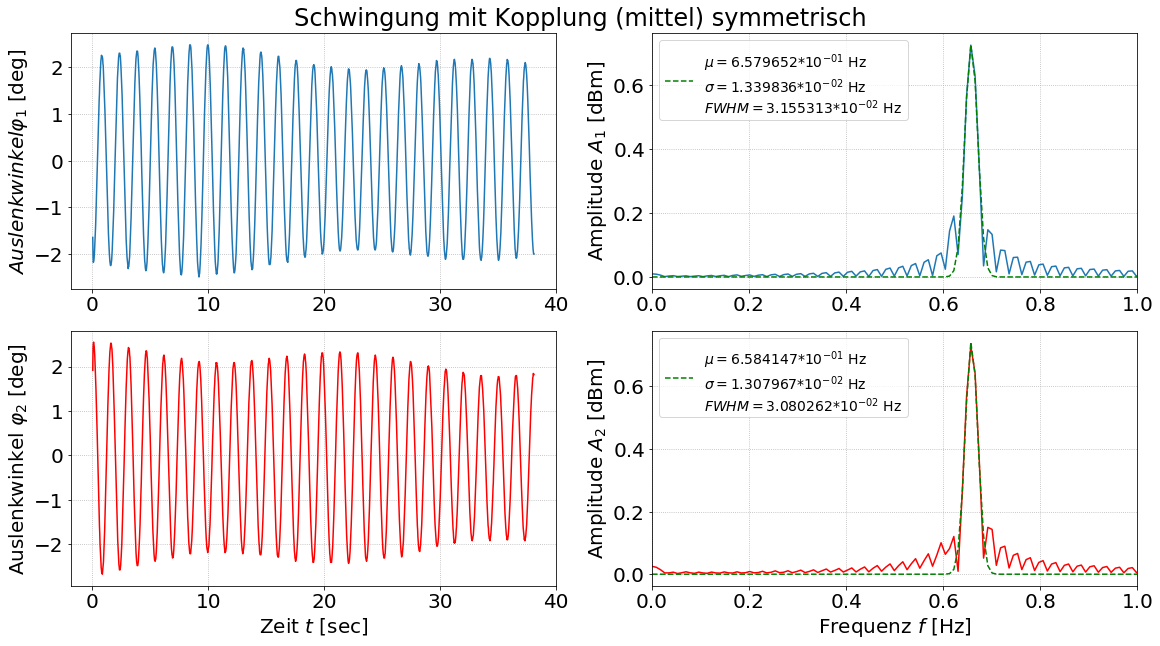


Gaussfit 1:
chi_squared= 2.635228e+02
chi_squared_red= 1.155802e-01
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Gaussfit 2:
chi_squared= 2.514409e+02
chi_squared_red= 1.102811e-01
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Eigenfrequenzen:

Pendel 1: w_1 = 0.658 ± 0.013  [Hz]
Pendel 2: w_2 = 0.658 ± 0.013  [Hz]
=> sig =  0.0 



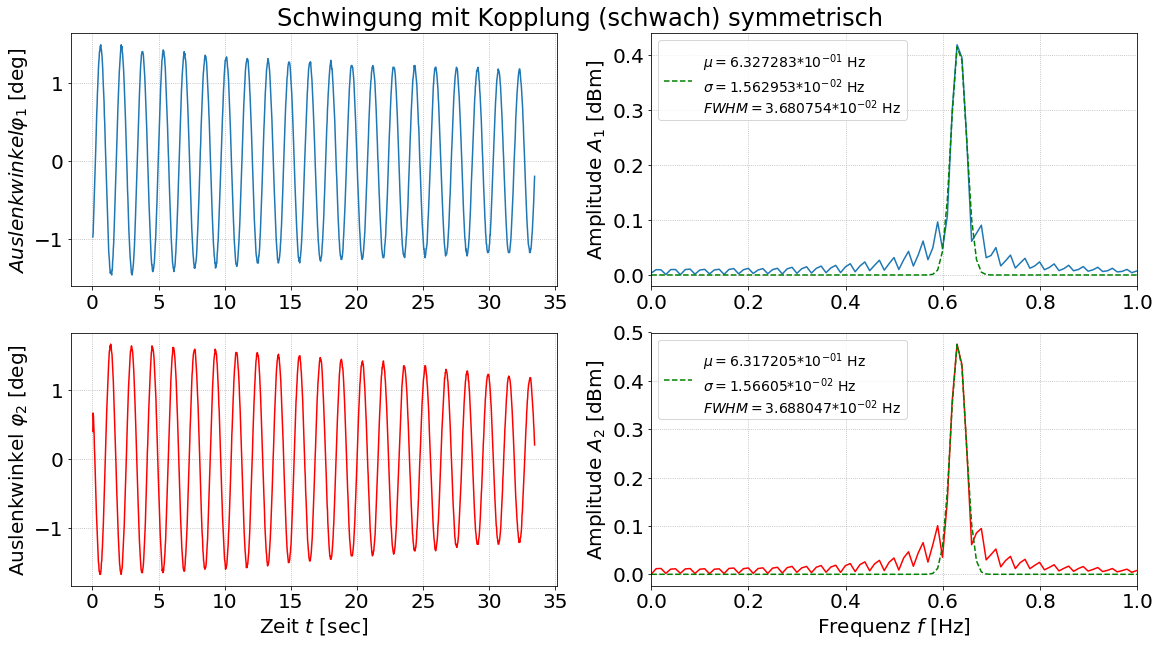


Gaussfit 1:
chi_squared= 8.452824e+01
chi_squared_red= 4.226412e-02
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Gaussfit 2:
chi_squared= 9.715834e+01
chi_squared_red= 4.857917e-02
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Eigenfrequenzen:

Pendel 1: w_1 = 0.633 ± 0.016  [Hz]
Pendel 2: w_2 = 0.632 ± 0.016  [Hz]
=> sig =  0.001 



In [7]:
A1s,dA1s,A2s,dA2s=plot_schwingung(2,'Schwingung mit Kopplung (stark) symmetrisch')
A1m,dA1m,A2m,dA2m=plot_schwingung(29,'Schwingung mit Kopplung (mittel) symmetrisch')
A1w,dA1w,A2w,dA2w=plot_schwingung(38,'Schwingung mit Kopplung (schwach) symmetrisch')

Die Eigenfrequenzen der beiden Pendel unterscheiden sich in jedem Fall nicht voneinander. Das system Schwingt mit **einer** Frequenz. Es ist aber ein deutlicher Abfall der Frequenz mit abnehmender Kopplung, zu erkennen.

### Berechnung der Eigenfrequenz $\omega_2^{\text{anti}}$

In [8]:
w_stark_ant, dw_stark_ant = np.mean([A1s,A2s]), dA1s+dA2s
w_mittel_ant, dw_mittel_ant = np.mean([A1m,A2m]), dA1m+dA2m
w_schwach_ant, dw_schwach_ant = np.mean([A1w,A2w]), dA1w+dA2w

print('\nEigenfrequenzen antisymmetrische Schwingung:\n')
print('Stark:   w_s =', form(w_stark_ant,dw_stark_ant), ' [Hz]')
print('Mittel:  w_m =', form(w_mittel_ant,dw_mittel_ant), ' [Hz]')
print('Schwach: w_w =', form(w_schwach_ant,dw_schwach_ant), ' [Hz]\n')
print('Abweichungen:\n')
print('=> sig_sm = ',sig(w_stark_ant,dw_stark_ant,w_mittel_ant,dw_mittel_ant))
print('=> sig_mw = ',sig(w_mittel_ant,dw_mittel_ant,w_schwach_ant,dw_schwach_ant))
print('=> sig_sw = ',sig(w_stark_ant,dw_stark_ant,w_schwach_ant,dw_schwach_ant))


Eigenfrequenzen antisymmetrische Schwingung:

Stark:   w_s = 0.726 ± 0.031  [Hz]
Mittel:  w_m = 0.658 ± 0.026  [Hz]
Schwach: w_w = 0.632 ± 0.031  [Hz]

Abweichungen:

=> sig_sm =  1.383
=> sig_mw =  0.202
=> sig_sw =  2.258


Die $\sigma$-Abweichung ist nun deutlich höher als im symmetrischen Fall, teilweise um eine Größenordnung mehr. Die Eigenfrequenz $\omega_2^{\text{anti}}$ des antisymmetrischen Systems ist somit **abhängig** von der Kopplung.

\begin{align}
    \omega_{2}^{\text{anti}}&=\sqrt{\frac{D+2 D^{\prime}}{J}}
\end{align}

Sie kann also nicht aus dem Mittelwert errechnet werden und muss für jede Kopplung einzeln aufgenommen werden. Es folgt somit:

| Kopplung  | Eigenfrequenz $\omega_2^{\text{anti}}$ [Hz] |
|-----------|---------------------------------------------|
| (stark)   | 0.726 $\pm$ 0.031                           |
| (mittel)  | 0.658 $\pm$ 0.026                           |
| (schwach) | 0.623 $\pm$ 0.031                           |

## Teil 3: Schwebungsschwingung

### Berechnung der Eigenfrequenz $\omega_I$ Schwebungsfrequenz $\omega_{II}$

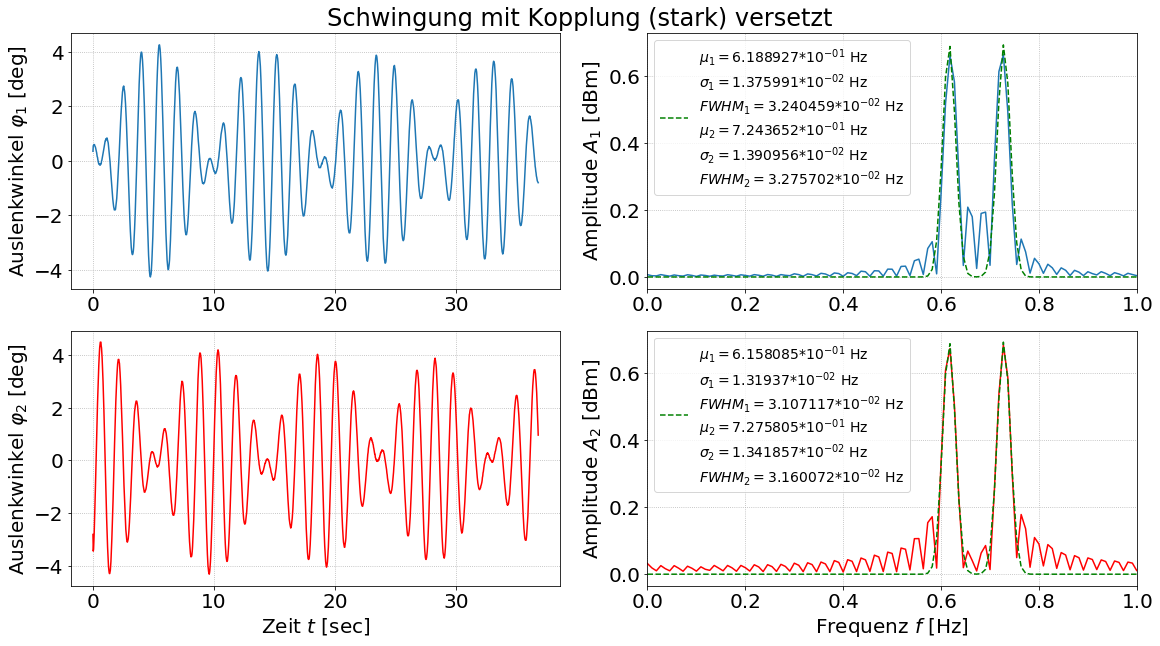


Gaussfit 1:
chi_squared= 3.335984e+04
chi_squared_red= 1.519118e+01
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 0.0 %

Gaussfit 2:
chi_squared= 4.744221e+04
chi_squared_red= 2.160392e+01
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 0.0 %

Eigenfrequenzen:

Pendel 1: w_I_1 = 0.724 ± 0.033  [Hz]
Pendel 2: w_I_2 = 0.728 ± 0.032  [Hz]
=> sig =  0.002 

Schwebungsfrequenzen:

Pendel 1: w_II_1 = 0.619 ± 0.032  [Hz]
Pendel 2: w_II_2 = 0.616 ± 0.031  [Hz]
=> sig =  0.002 



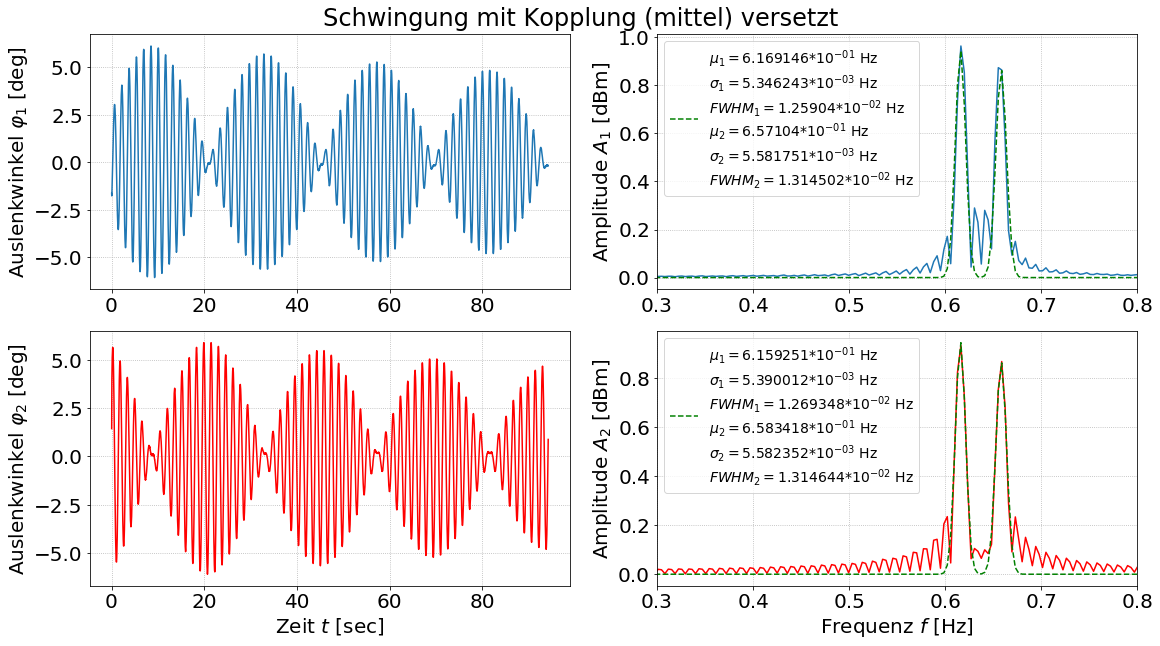


Gaussfit 1:
chi_squared= 4.649294e+01
chi_squared_red= 8.243429e-03
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Gaussfit 2:
chi_squared= 5.961257e+01
chi_squared_red= 1.056961e-02
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Eigenfrequenzen:

Pendel 1: w_I_1 = 0.657 ± 0.013  [Hz]
Pendel 2: w_I_2 = 0.658 ± 0.013  [Hz]
=> sig =  0.002 

Schwebungsfrequenzen:

Pendel 1: w_II_1 = 0.617 ± 0.013  [Hz]
Pendel 2: w_II_2 = 0.616 ± 0.013  [Hz]
=> sig =  0.002 



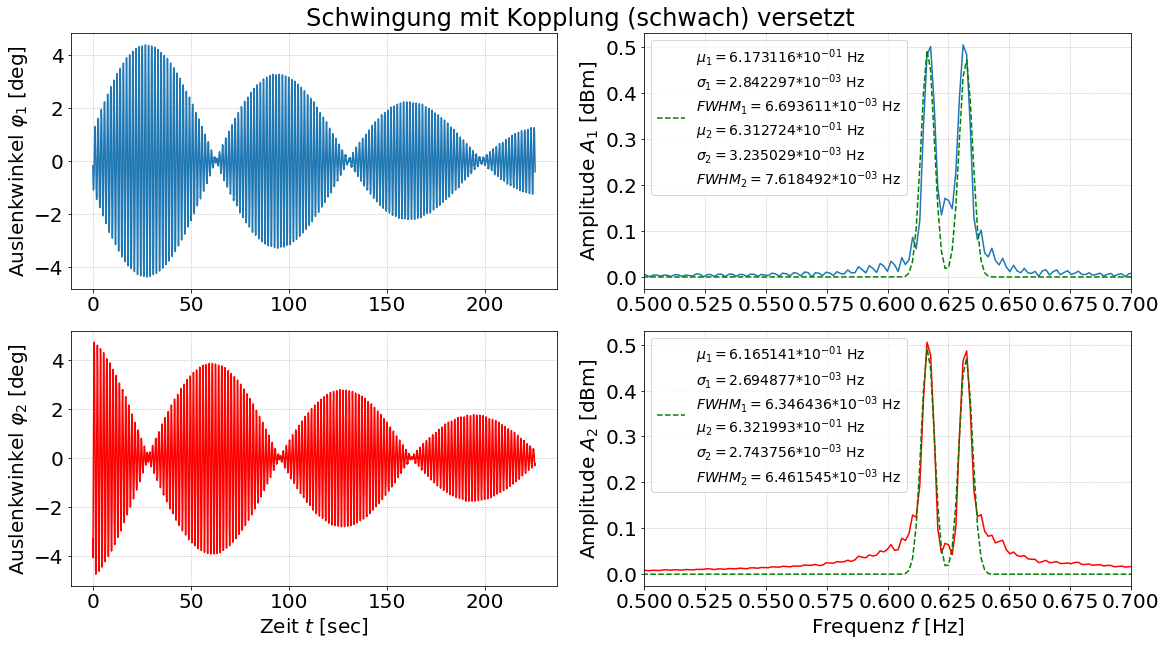


Gaussfit 1:
chi_squared= 5.617307e+03
chi_squared_red= 4.162202e-01
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 100.0 %

Gaussfit 2:
chi_squared= 1.39161e+04
chi_squared_red= 1.031128e+00
Wahrscheinlichkeit ein größeres oder gleiches Chi-Quadrat zu erhalten: 1.0 %

Eigenfrequenzen:

Pendel 1: w_I_1 = 0.631 ± 0.008  [Hz]
Pendel 2: w_I_2 = 0.632 ± 0.006  [Hz]
=> sig =  0.004 

Schwebungsfrequenzen:

Pendel 1: w_II_1 = 0.617 ± 0.007  [Hz]
Pendel 2: w_II_2 = 0.617 ± 0.006  [Hz]
=> sig =  0.004 



In [9]:
def plot_schwingung_doppelgauss(n,title,h,a,b):
    t, phi1, phi2 = open_data(n)
    F1, A1, F2, A2 = fastfourier(n)
    
    from scipy.signal import find_peaks
    peaks1, _ = find_peaks(A1, height=0.4)
    init_vals1 = [0.002, F1[peaks1][0], 0.005, 0.002, F1[peaks1][1], 0.005]
    peaks2, _ = find_peaks(A2, height=0.4)
    init_vals2 = [0.002, F2[peaks2][0], 0.005, 0.002, F2[peaks2][1], 0.005]
    
    popt1, pcov1 = curve_fit(gaussian2,F1, A1, p0=init_vals1)
    perr1 = np.sqrt(np.diag(pcov1))
    popt2, pcov2 = curve_fit(gaussian2,F2, A2, p0=init_vals2)
    perr2 = np.sqrt(np.diag(pcov2))

    fig, axs = plt.subplots(2, 2, constrained_layout=True)

    axs[0,0].plot(t, phi1)
    #axs[0].set_xlabel('time [sec]')
    axs[0,0].set_ylabel('Auslenkwinkel $\\varphi_1$ [deg]')
    axs[0,0].grid(ls=':')

    axs[1,0].plot(t, phi2,c='red')
    axs[1,0].set_xlabel('Zeit $t$ [sec]')
    axs[1,0].set_ylabel('Auslenkwinkel $\\varphi_2$ [deg]')
    axs[1,0].grid(ls=':')
    
    axs[0,1].plot(F1, A1)
    axs[0,1].plot(F2, gaussian2(F2,popt2[0],popt2[1],popt2[2],
                          popt2[3],popt2[4],popt2[5]),c='g',ls='--',
                  label=r'$\mu_1 = $'+format_plt(popt1[1])+' Hz\n'
                  +r'$\sigma_1 = $'+format_plt(popt1[2])+' Hz\n'
                  +r'$FWHM_1 = $'+format_plt(popt1[2]*2.355)+' Hz\n'
                  +r'$\mu_2 = $'+format_plt(popt1[4])+' Hz\n'
                  +r'$\sigma_2 = $'+format_plt(popt1[5])+' Hz\n'
                  +r'$FWHM_2 = $'+format_plt(popt1[5]*2.355)+' Hz')
    axs[0,1].set_xlim(a,b)
    axs[0,1].set_ylabel('Amplitude $A_1$ [dBm]')
    axs[0,1].grid(ls=':')
    axs[0,1].legend(loc='best', fontsize=14)

    axs[1,1].plot(F2, A2,c='red')
    axs[1,1].plot(F2, gaussian2(F2,popt2[0],popt2[1],popt2[2],
                          popt2[3],popt2[4],popt2[5]),c='g',ls='--',
                  label=r'$\mu_1 = $'+format_plt(popt2[1])+' Hz\n'
                  +r'$\sigma_1 = $'+format_plt(popt2[2])+' Hz\n'
                  +r'$FWHM_1 = $'+format_plt(popt2[2]*2.355)+' Hz\n'
                  +r'$\mu_2 = $'+format_plt(popt2[4])+' Hz\n'
                  +r'$\sigma_2 = $'+format_plt(popt2[5])+' Hz\n'
                  +r'$FWHM_2 = $'+format_plt(popt2[5]*2.355)+' Hz')
    axs[1,1].set_xlim(a,b)
    axs[1,1].set_xlabel('Frequenz $f$ [Hz]')
    axs[1,1].set_ylabel('Amplitude $A_2$ [dBm]')
    axs[1,1].grid(ls=':')
    axs[1,1].legend(loc='best', fontsize=14)

    fig.suptitle(title)
    plt.show()
    
    wII1,dwII1,wII2,dwII2 = popt1[1], popt1[2]*2.355, popt2[1], popt2[2]*2.355
    wI1,dwI1,wI2,dwI2 = popt1[4], popt1[5]*2.355, popt2[4], popt2[5]*2.355
    
    diff_peaks1 = np.abs(np.diff(A1[peaks1]))
    diff_peaks2 = np.abs(np.diff(A1[peaks1]))
    
    print('\nGaussfit 1:')
    fitgüte(F1,A1,diff_peaks1,popt1,gaussian2)
    print('\nGaussfit 2:')
    fitgüte(F2,A2,diff_peaks2,popt2,gaussian2)
    
    print('\nEigenfrequenzen:\n')
    print('Pendel 1: w_I_1 =', form(wI1,dwI1), ' [Hz]')
    print('Pendel 2: w_I_2 =', form(wI2,dwI2), ' [Hz]')
    print('=> sig = ',sig(wI1,dwI1,wI2,dwI2),'\n')
    
    print('Schwebungsfrequenzen:\n')
    print('Pendel 1: w_II_1 =', form(wII1,dwII1), ' [Hz]')
    print('Pendel 2: w_II_2 =', form(wII2,dwII2), ' [Hz]')
    print('=> sig = ',sig(wII1,dwII1,wII2,dwII2),'\n')
    
    w_I,dw_I = np.mean([wI1,wI2]), dwI1+dwI2
    w_II,dw_II = np.mean([wII1,wII2]), dwII1+dwII2
    
    return [w_I,dw_I],[w_II,dw_II]
a = 'Schwingung mit Kopplung (stark) versetzt'
Sch1s, Sch2s = plot_schwingung_doppelgauss(39,a,0.4,0,1)
b = 'Schwingung mit Kopplung (mittel) versetzt'
Sch1m, Sch2m = plot_schwingung_doppelgauss(32,b,0.4,0.3,0.8)
c = 'Schwingung mit Kopplung (schwach) versetzt'
Sch1w, Sch2w = plot_schwingung_doppelgauss(40,c,0.4,0.5,0.7)

## Vergleich von $\omega_I$ und $\omega_{II}$ bei verschiedenen Kopplungen

In [10]:
w_I_s,dw_I_s,w_II_s,dw_II_s = Sch1s[0],Sch1s[1],Sch2s[0],Sch2s[1]
w_I_m,dw_I_m,w_II_m,dw_II_m = Sch1m[0],Sch1m[1],Sch2m[0],Sch2m[1]
w_I_w,dw_I_w,w_II_w,dw_II_w = Sch1w[0],Sch1w[1],Sch2w[0],Sch2w[1]

print('\nEigenfrequenzen w_I bei verschiedenen Kopplungen:\n')
print('Stark:   w_I_s =', form(w_I_s,dw_I_s), ' [Hz]')
print('Mittel:  w_I_m =', form(w_I_m,dw_I_m), ' [Hz]')
print('Schwach: w_I_w =', form(w_I_w,dw_I_w), ' [Hz]\n')
print('Abweichungen:\n')
print('=> sig_sm = ',sig(w_I_s,dw_I_s,w_I_m,dw_I_m))
print('=> sig_mw = ',sig(w_I_m,dw_I_m,w_I_w,dw_I_w))
print('=> sig_sw = ',sig(w_I_s,dw_I_s,w_I_w,dw_I_w),'\n')

print('\nSchwebungsfrequenzen w_II bei verschiedenen Kopplungen:\n')
print('Stark:   w_II_s =', form(w_II_s,dw_II_s), ' [Hz]')
print('Mittel:  w_II_m =', form(w_II_m,dw_II_m), ' [Hz]')
print('Schwach: w_II_w =', form(w_II_w,dw_II_w), ' [Hz]\n')
print('Abweichungen:\n')
print('=> sig_sm = ',sig(w_II_s,dw_II_s,w_II_m,dw_II_m))
print('=> sig_mw = ',sig(w_II_m,dw_II_m,w_II_w,dw_II_w))
print('=> sig_sw = ',sig(w_II_s,dw_II_s,w_II_w,dw_II_w))


Eigenfrequenzen w_I bei verschiedenen Kopplungen:

Stark:   w_I_s = 0.726 ± 0.064  [Hz]
Mittel:  w_I_m = 0.658 ± 0.026  [Hz]
Schwach: w_I_w = 0.632 ± 0.014  [Hz]

Abweichungen:

=> sig_sm =  0.567
=> sig_mw =  0.414
=> sig_sw =  1.443 


Schwebungsfrequenzen w_II bei verschiedenen Kopplungen:

Stark:   w_II_s = 0.617 ± 0.063  [Hz]
Mittel:  w_II_m = 0.616 ± 0.025  [Hz]
Schwach: w_II_w = 0.617 ± 0.013  [Hz]

Abweichungen:

=> sig_sm =  0.0
=> sig_mw =  0.0
=> sig_sw =  0.0


Die Eigenfrequenz $\omega_I$ des Systems weist keine signifikanten Abweichungen mit steigender Kopplung auf (max. 0.34$\sigma$), während diese in der Schwebungsfrequenz $\omega_{II}$ deutlich zu erkennen sind (min. 8.31$\sigma$). 
Außerdem soll überprüft werden wie $\omega_I$, $\omega_{II}$ sich gemäß der Theorie verhalten: 

\begin{align}
    \omega_I &= \frac{1}{2}(\omega_1^{\text{sys}} + \omega_2^{\text{anti}})\\
    \omega_{II} &= \frac{1}{2}(\omega_2^{\text{anti}} - \omega_1^{\text{sys}})
\end{align}

In [11]:
def vergleich_theo(stärke):
    if stärke == 'Stark':
        w_ant = w_stark_ant
        dw_ant = dw_stark_ant
        w_I = w_I_s
        dw_I = dw_I_s
        w_II = w_II_s
        dw_II = dw_II_s
        a = 's'
    if stärke == 'Mittel':
        w_ant = w_mittel_ant
        dw_ant = dw_mittel_ant
        w_I = w_I_m
        dw_I = dw_I_m
        w_II = w_II_m
        dw_II = dw_II_m
        a = 'm'
    if stärke == 'Schwach':
        w_ant = w_schwach_ant
        dw_ant = dw_schwach_ant
        w_I = w_I_w
        dw_I = dw_I_w
        w_II = w_II_w
        dw_II = dw_II_w
        a = 'w'
    
    w_I_theo = 1/2*(w_sys + w_ant)
    dw_I_theo = np.sqrt((0.5*dw_sys)**2+(dw_ant)**2)
    w_II_theo = 1/2*(w_ant - w_sys)
    dw_II_theo = np.sqrt((0.5*dw_sys)**2+(dw_ant)**2)
    
    print('\n'+stärke+':')
    print('w_I_'+stärke+'      = ', form(w_I,dw_I), ' [Hz]')
    print('w_I_'+stärke+'_theo = ', form(w_I_theo,dw_I_theo), ' [Hz]')
    print('=> sig = ', sig(w_I,dw_I,w_I_theo,dw_I_theo))
    print('w_II_'+stärke+'      = ', form(w_II,dw_II), ' [Hz]')
    print('w_II_'+stärke+'_theo = ', form(w_II_theo,dw_II_theo), ' [Hz]')
    print('=> sig = ', sig(w_II,dw_II,w_II_theo,dw_II_theo))
vergleich_theo('Stark')
vergleich_theo('Mittel')
vergleich_theo('Schwach')


Stark:
w_I_Stark      =  0.726 ± 0.064  [Hz]
w_I_Stark_theo =  0.671 ± 0.036  [Hz]
=> sig =  0.301
w_II_Stark      =  0.617 ± 0.063  [Hz]
w_II_Stark_theo =  0.054 ± 0.036  [Hz]
=> sig =  32.277

Mittel:
w_I_Mittel      =  0.658 ± 0.026  [Hz]
w_I_Mittel_theo =  0.637 ± 0.032  [Hz]
=> sig =  0.122
w_II_Mittel      =  0.616 ± 0.025  [Hz]
w_II_Mittel_theo =  0.021 ± 0.032  [Hz]
=> sig =  108.587

Schwach:
w_I_Schwach      =  0.632 ± 0.014  [Hz]
w_I_Schwach_theo =  0.624 ± 0.036  [Hz]
=> sig =  0.021
w_II_Schwach      =  0.617 ± 0.013  [Hz]
w_II_Schwach_theo =  0.008 ± 0.036  [Hz]
=> sig =  154.442


### Zusammenfassung der Ergebnisse

Die numerisch errechneten Werte der Eigenfrequenzen $\omega_{I}$ stimmen gut mit den theoretischen Vorhersagen überein. Die $\sigma$-Abweichungen sind sehr gering. Die Ergebnisse für den Vergelich der Eigenfrequenzen $\omega_{I}$ der Schwebungsschwingung sind in folgender Tabelle zusammengetragen:

|Kopplung|$\omega_1^{\text{sym}}$ [Hz]|$\omega_2^{\text{anti}}$ [Hz]|$\omega_{I}^{\text{fft}}$ [Hz] |$\omega_{I}^{\text{theo}}$ [Hz]|$\sigma$-Abw.|
|---|---|---|---|---|---|
| (stark)   | 0.617 $\pm$ 0.039                          | 0.726 $\pm$ 0.031                           | 0.726 $\pm$ 0.064                            | 0.671 $\pm$ 0.036                             | 0.30          |
| (mittel)  | 0.617 $\pm$ 0.039                          | 0.658 $\pm$ 0.026                           | 0.658 $\pm$ 0.026                            | 0.637 $\pm$ 0.037                             | 0.12          |
| (schwach) | 0.617 $\pm$ 0.039                          | 0.623 $\pm$ 0.031                           | 0.623 $\pm$ 0.014                            | 0.624 $\pm$ 0.036                             | 0.02           |

Die Numerische berechnung der Werte für $\omega_{II}$ und die theoretische Vorhersage aus den zuvor bestimmten Messwerten stimmen nicht überein, die Abweichungen sind **sehr** hoch. Die Ergebnisse für den Vergleich der Schwebungsfrequenzen $\omega_{II}$ in der Schwebungsschwingung sind in folgender Tabelle zusammengetragen:

|Kopplung|$\omega_1^{\text{sym}}$ [Hz]|$\omega_2^{\text{anti}}$ [Hz]|$\omega_{II}^{\text{fft}}$ [Hz]|$\omega_{II}^{\text{theo}}$ [Hz]|$\sigma$-Abw.|
|---|---|---|---|---|---|
| (stark) | 0.617 $\pm$ 0.039 | 0.726 $\pm$ 0.031 | 0.617 $\pm$ 0.036 | 0.054 $\pm$ 0.036 | 32.28 |
| (mittel) | 0.617 $\pm$ 0.039 | 0.658 $\pm$ 0.026 | 0.616 $\pm$ 0.025 | 0.021 $\pm$ 0.032 | 108.59 |
| (schwach) | 0.617 $\pm$ 0.039 | 0.623 $\pm$ 0.031 | 0.617 $\pm$ 0.013 | 0.008 $\pm$ 0.036 | 154.44 |

Auch die mit der alternativen Definition für $\omega_{II}$, ist die geringste $\sigma$-Abweichung die, der stärksten Kopplung, mit $\approx 26 \sigma$ und immernoch **signifikant** verschieden.

## Teil 4: Kopplugsgrad $\kappa$

In [12]:

def Kopplungsgrad(w1,dw1,w2,dw2):
    k = np.abs((w1**2-w2**2))/(w1**2+w2**2)
    dk = np.sqrt(((4*w1*w2**2)/(w1**2+w2**2)**2 *dw1)**2+
                 ((4*w1**2*w2)/(w1**2+w2**2)**2*dw2)**2)
    return k, dk

def Kappa(stärke):
    if stärke == 'Stark  ':
        w_ant = w_stark_ant
        dw_ant = dw_stark_ant
        a = 's'
    if stärke == 'Mittel ':
        w_ant = w_mittel_ant
        dw_ant = dw_mittel_ant
        a = 'm'
    if stärke == 'Schwach':
        w_ant = w_schwach_ant
        dw_ant = dw_schwach_ant
        a = 'w'
    
    k, dk = Kopplungsgrad(w_sys,dw_sys,w_ant,dw_ant)
    print(stärke+': k_'+a+' = ', format_e(k), '±', format_e(dk))
    #print(stärke+': k_'+a+' = ', form(k,dk))
    return k, dk
print('\nKopplungsgrad:\n')
k_s, dk_s = Kappa('Stark  ')
k_m, dk_m = Kappa('Mittel ')
k_w, dk_w = Kappa('Schwach')
print('')


Kopplungsgrad:

Stark  : k_s =  1.612167e-01 ± 6.972389e-02
Mittel : k_m =  6.501623e-02 ± 6.994455e-02
Schwach: k_w =  2.48538e-02 ± 7.588058e-02



| Kopplung | Kopplungsgrad $\kappa$ |
|---|---|
| (stark) | 0.161 $\pm$ 0.070 |
| (mittel) | 0.065 $\pm$ 0.070 |
| (schwach | 0.025 $\pm$ 0.076 |

### Verhältnisse der Kopplungsgrade

In [13]:
ls, lm, lw, dl = 0.40, 0.25, 0.15, 0.002 # Kopplungslänge [m]

diff_k_sm, ddiff_k_sm = k_s/k_m, max(dk_s,dk_m)
diff_k_mw, ddiff_k_mw = k_m/k_w, max(dk_m,dk_w)
diff_k_sw, ddiff_k_sw = k_s/k_w, max(dk_s,dk_w)

diff_l_sm, ddiff_l_sm = ls**2/lm**2, ls
diff_l_mw, ddiff_l_mw = lm**2/lw**2, ls
diff_l_sw, ddiff_l_sw = ls**2/lw**2, ls

print('\nVerhältnisse von k und l\n')
print('diff_k_sm = ', form(diff_k_sm,ddiff_k_sm))
print('diff_l_sm = ', form(diff_l_sm,ddiff_l_sm))
print('=> sig = ', sig(diff_k_sm,ddiff_k_sm,diff_l_sm, ddiff_l_sm),'\n')
print('diff_k_mw = ', form(diff_k_mw,ddiff_k_mw))
print('diff_l_mw = ', form(diff_l_sm,ddiff_l_mw))
print('=> sig = ', sig(diff_k_mw,ddiff_k_mw,diff_l_mw, ddiff_l_mw),'\n')
print('diff_k_sw = ', form(diff_k_sw,ddiff_k_sw))
print('diff_l_sw = ', form(diff_l_sw,ddiff_l_sw))
print('=> sig = ', sig(diff_k_sw,ddiff_k_sw,diff_l_sw, ddiff_l_sw),'\n')


Verhältnisse von k und l

diff_k_sm =  2.480 ± 0.070
diff_l_sm =  2.560 ± 0.400
=> sig =  0.029 

diff_k_mw =  2.616 ± 0.076
diff_l_mw =  2.560 ± 0.400
=> sig =  0.116 

diff_k_sw =  6.487 ± 0.076
diff_l_sw =  7.111 ± 0.400
=> sig =  1.722 



Der Vergleich zeigt, das die Verhältnisse der Kopplungsgraden $\kappa$ mit denen der Kopplungslängen-quadraten $l^2$ gut übereinstimmen. Dabei ist die übereinstimmung bei stärkerer Kopplung am höchsten. Die Ergebnisse sind in folgender Tabelle zusammengetragen:

| Verhältniss | Kopplungsgrad $\kappa$ | Kopplungslängen-quadrat $l^2$ | $\sigma$-Abw. |
|---|---|---|---|
| (stark)/(mittel) | 2.480 $\pm$ 0.070 | 2.560 $\pm$ 0.400 | 0.03 |
| (mittel)/(schwach) | 2.616 $\pm$ 0.076 | 2.560 $\pm$ 0.400 | 0.12 |
| (stark)/(schwach) | 6.487 $\pm$ 0.076 | 7.111 $\pm$ 0.400 | 1.72 |